In [47]:
import ortools
from ortools.constraint_solver import routing_enums_pb2
import ortools.constraint_solver.pywrapcp as pywrapcp
from PIL import Image
from IPython.display import display
import pandas as pd
from itertools import zip_longest
from geopy.distance import geodesic


import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

import numpy as np

import requests

import folium

import seaborn as sns

import itertools
import math

In [48]:
caminho = r"C:\Users\MarkosPereira.exc\Downloads\ara_adm (1).xlsx".replace("\\","/")
teste = pd.read_excel(caminho)
teste = teste.drop_duplicates()
teste = teste.reset_index()
teste['lat'] = teste['lat'].astype(str)
teste['long'] = teste['long'].astype(str)
teste['lat'] = teste['lat'].str.replace(",",".")
teste['long'] = teste['long'].str.replace(",",".")
teste['lat'] = teste['lat'].astype(float)
teste['long'] = teste['long'].astype(float)
teste['qtd'] = teste['qtd'].astype(int)
teste.head()

,index,nome_local,qtd,lat,long,rota_original
0,0,Fábrica,0,-19.837913,-40.082170,-1
1,1,Ponto ao lado do antigo DPM,5,-19.903273,-40.232890,0
2,2,Primo Bitti - Parada do Caranguejo - Irajá,2,-19.904354,-40.223015,0
3,3,Primo Bitti-início de Caieiras Velha- prox. Es...,2,-19.920553,-40.174908,0
4,4,Primo Bitti - Saída de Caieiras Velha sent. Co...,2,-19.927172,-40.164630,0


# Criação distance Matrix

In [49]:
x = list(zip_longest(teste['lat'][:], teste['long'][:], fillvalue=None))

In [50]:
# Crie uma matriz de distância vazia
distance_matrix = []

# Calcule as distâncias entre todos os pares de coordenadas
for coord1 in x:
    distances = []
    for coord2 in x:
        distancia = geodesic(coord1, coord2).kilometers
        distances.append(distancia)
    distance_matrix.append(distances)

# Criação dos cluster de dados para agrupar os pontos de embarque

In [51]:
def cluster_data(data_frame, n_clusters):
    # Selecionar as colunas 'lat' e 'long'
    features = data_frame[['lat', 'long']]

    # Padronizar as features para média zero e desvio padrão 1
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Executar o algoritmo K-Means com o número de grupos especificado
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    data_frame['cluster'] = kmeans.fit_predict(scaled_features)
    data_frame = data_frame.assign(row=1)

    return data_frame

In [52]:
# Carregar seu DataFrame pandas com as colunas 'lat' e 'long'
# df = pd.read_csv('seuarquivo.csv')

# Especificar o número desejado de grupos (n)
n = 16
n_clusters = int(n**0.5)

# Chamar a função para agrupar os dados em n grupos
clustered_df = cluster_data(teste[1:], n_clusters)
clustered_df.head(5)

,index,nome_local,qtd,lat,long,rota_original,cluster,row
1,1,Ponto ao lado do antigo DPM,5,-19.903273,-40.232890,0,0,1
2,2,Primo Bitti - Parada do Caranguejo - Irajá,2,-19.904354,-40.223015,0,0,1
3,3,Primo Bitti-início de Caieiras Velha- prox. Es...,2,-19.920553,-40.174908,0,2,1
4,4,Primo Bitti - Saída de Caieiras Velha sent. Co...,2,-19.927172,-40.164630,0,2,1
5,5,Rod. Primo Bitti - Caixa Dagua Cohab,3,-19.930769,-40.152954,0,2,1


# Visualização dos cluster de dados

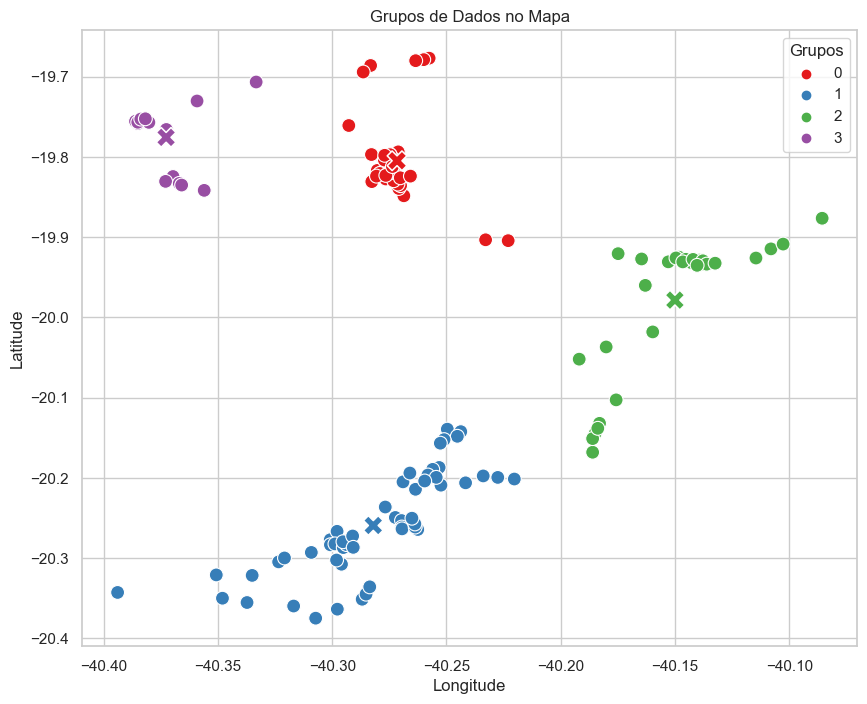

In [53]:
def plot_clusters_on_map(data_frame, lat_col, long_col, cluster_col):
    # Extrair as coordenadas de latitude e longitude e os rótulos de grupo
    lats = data_frame[lat_col]
    longs = data_frame[long_col]
    clusters = data_frame[cluster_col]

    # Configurar o estilo do gráfico de dispersão
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 8))

    # Plotar os pontos coloridos por grupo
    sns.scatterplot(x=longs, y=lats, hue=clusters, palette='Set1', s=100, legend='full')

    # Configurar rótulos e título
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Grupos de Dados no Mapa')

    # Mostrar a legenda
    plt.legend(title='Grupos', loc='upper right')

    # Calcular e plotar os centroides dos clusters
    centroids = data_frame.groupby(cluster_col)[[lat_col, long_col]].mean().reset_index()
    sns.scatterplot(x=centroids[long_col], y=centroids[lat_col], hue=centroids[cluster_col],
                    palette='Set1', s=200, marker='X', legend=False, ax=plt.gca())

    # Exibir o mapa
    plt.show()

    return centroids


# Carregar seu DataFrame pandas com as colunas 'lat', 'long', e 'cluster'
# df = pd.read_csv('seuarquivo.csv')

# Chamar a função para plotar os grupos no mapa
x = plot_clusters_on_map(clustered_df, 'lat', 'long', 'cluster')

In [54]:
y = clustered_df[['cluster', 'qtd', 'row']].groupby('cluster').sum(['qtd', 'row']).sort_values('qtd', ascending=False)
y = y.reset_index()

In [55]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Raio da Terra em quilômetros
    radius = 6371

    # Converte graus para radianos
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Diferenças de latitude e longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = radius * c

    return distance

In [56]:
def calcular_proporcionais(valores, valor_base):
    # Verifica se a lista de valores não está vazia
    if not valores:
        return []

    # Calcula a soma dos valores na lista
    soma_valores = sum(valores)

    # Calcula os fatores de escala para manter a proporção
    fatores_escala = [valor_base / soma_valores * valor for valor in valores]

    # Arredonda os fatores de escala para números inteiros
    fatores_inteiros = [round(fator) for fator in fatores_escala]

    # Ajusta para garantir que a soma seja igual ao valor base
    diferenca = valor_base - sum(fatores_inteiros)
    fatores_inteiros[-1] += diferenca

    return fatores_inteiros

In [57]:
z = pd.merge(x, y, on='cluster')
z= z.assign(lat1= -19.837913) 
z= z.assign(long1= -40.082170)
z['distance'] = haversine_distance(z['lat'], z['long'], z['lat1'], z['long1'])
z = z.sort_values('qtd', ascending=False)
z

,cluster,lat,long,qtd,row,lat1,long1,distance
0,0,-19.804766,-40.271641,329,43,-19.837913,-40.08217,20.159769
3,3,-19.775597,-40.372692,130,16,-19.837913,-40.08217,31.173276
1,1,-20.259355,-40.282038,99,52,-19.837913,-40.08217,51.302437
2,2,-19.978421,-40.150058,79,31,-19.837913,-40.08217,17.160378


In [58]:
base = 16
resultado = calcular_proporcionais(list(z['qtd']), base)
z['n_routs'] = resultado
z

,cluster,lat,long,qtd,row,lat1,long1,distance,n_routs
0,0,-19.804766,-40.271641,329,43,-19.837913,-40.08217,20.159769,8
3,3,-19.775597,-40.372692,130,16,-19.837913,-40.08217,31.173276,3
1,1,-20.259355,-40.282038,99,52,-19.837913,-40.08217,51.302437,2
2,2,-19.978421,-40.150058,79,31,-19.837913,-40.08217,17.160378,3


# Definição dos pontos de START das rotas

In [59]:
def calculate_best_starting_points_with_destination(latitudes, longitudes, demands, destination_latitude, destination_longitude, num_vehicles):
    # Índices possíveis para pontos de início
    possible_starts = list(range(len(latitudes)))

    # Combinar os índices dos pontos de início com a demanda total
    start_combinations = itertools.combinations(possible_starts, num_vehicles)

    best_starts_indices = min(start_combinations, key=lambda indices: sum(demands[i] for i in indices))

    # Obter as coordenadas correspondentes aos melhores pontos de início
    best_starting_points = [(latitudes[i], longitudes[i]) for i in best_starts_indices]

    # Adicionar o ponto de destino
    best_starting_points.append((destination_latitude, destination_longitude))

    return best_starting_points


In [60]:
list_od_stars_points = list()
for cluster in z['cluster'].unique():
    new_df = clustered_df[clustered_df['cluster']==cluster]
    n_points = z[z['cluster']==cluster]['n_routs'].unique()[0]
#     print(n_points)
    best_starting_points = calculate_best_starting_points_with_destination(list(new_df['lat']), list(new_df['long']),list(new_df['qtd']), -19.837913,-40.082170, n_points)
    list_od_stars_points.append(best_starting_points)
#     display(new_df)
#     print(best_starting_points)
print(list_od_stars_points)

[[(-19.904354, -40.223015), (-19.807047, -40.275913), (-19.823917, -40.28063), (-19.678738, -40.25997), (-19.686018, -40.283215), (-19.694153, -40.28645), (-19.760822, -40.292744), (-19.803783, -40.277172), (-19.837913, -40.08217)], [(-19.75676, -40.38095), (-19.752441, -40.381767), (-19.832977, -40.366905), (-19.837913, -40.08217)], [(-20.374887, -40.307243), (-20.363674, -40.297768), (-19.837913, -40.08217)], [(-19.92495, -40.148243), (-19.934164, -40.137684), (-19.935116, -40.140347), (-19.837913, -40.08217)]]


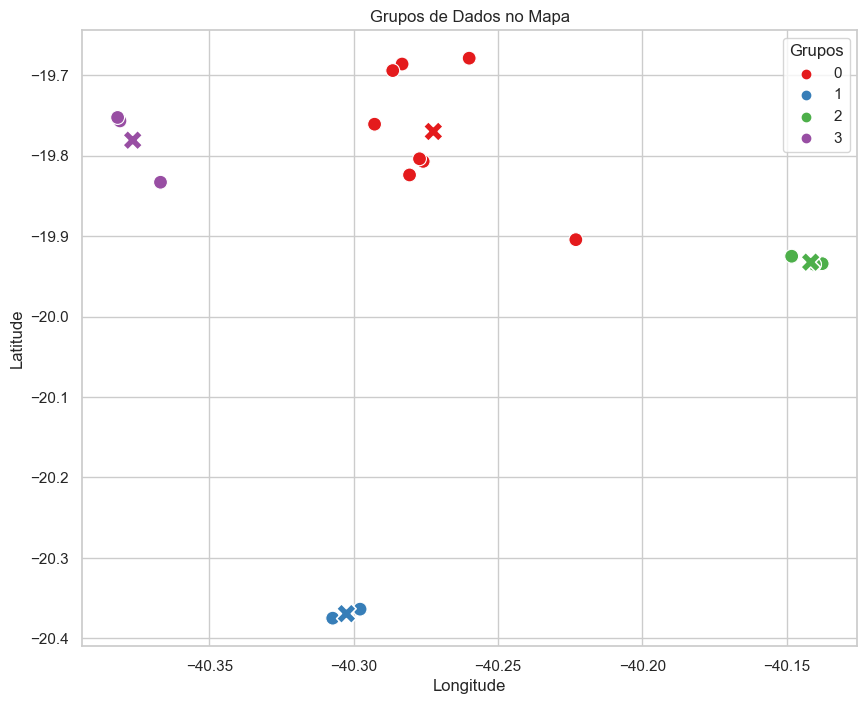

In [61]:
start_latitudes = list()
start_longitudes = list()
for points in list_od_stars_points:
    for point in points:
        start_latitudes.append(point[0])
        start_longitudes.append(point[1])
        
new_df = pd.DataFrame({'lat': start_latitudes, 'long': start_longitudes})
new_df_2 = pd.merge(new_df, clustered_df, on = ['lat', 'long'])

x = plot_clusters_on_map(new_df_2, 'lat', 'long', 'cluster')

# Momento Gambiarra corrigir

In [66]:
new_df_2.head(3)

,lat,long,index,nome_local,qtd,rota_original,cluster,row
0,-19.904354,-40.223015,2,Primo Bitti - Parada do Caranguejo - Irajá,2,0,0,1
1,-19.807047,-40.275913,30,Av.Venancio Flores - Posto de Saúde,3,3,0,1
2,-19.823917,-40.280630,42,Posto Golfinho,2,6,0,1


In [84]:
starts = [2, 30, 42, 47, 49, 50, 51, 53, 56, 64, 73, 82, 83, 6, 10, 11]
vehicle_capacities = [46 for _ in range(16)]
ends = [0 for _ in range(16)]
depot = 0
num_vehicles = 16
demands = list(teste['qtd'])

In [85]:
print(len(vehicle_capacities))
print(len(ends))
print(len(starts))
print(starts)

16
16
16
[2, 30, 42, 47, 49, 50, 51, 53, 56, 64, 73, 82, 83, 6, 10, 11]


# Projeção da rotas

In [86]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(distance_matrix, demands, vehicle_capacities, num_vehicles, depot, starts, ends):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["demands"] = demands
    data["vehicle_capacities"] = vehicle_capacities
    data["num_vehicles"] = num_vehicles
    data["depot"] = depot
    data["starts"] = starts
    data["ends"] = ends
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    #####
    max_route_distance = 0
    #####
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(distance_matrix, demands, vehicle_capacities, num_vehicles, depot, starts, ends)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["starts"], data["ends"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
#         routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC
    )
    search_parameters.log_search = True
    search_parameters.time_limit.FromSeconds(15)
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == "__main__":
    main()


Objective: 520
Route for vehicle 0:
 2 Load(2) ->  33 Load(10) ->  35 Load(27) ->  34 Load(45) ->  0 Load(45)
Distance of the route: 27m
Load of the route: 45

Route for vehicle 1:
 30 Load(3) ->  37 Load(14) ->  36 Load(26) ->  26 Load(36) ->  43 Load(41) ->  32 Load(46) ->  0 Load(46)
Distance of the route: 21m
Load of the route: 46

Route for vehicle 2:
 42 Load(2) ->  25 Load(21) ->  75 Load(23) ->  24 Load(37) ->  80 Load(46) ->  0 Load(46)
Distance of the route: 35m
Load of the route: 46

Route for vehicle 3:
 47 Load(1) ->  48 Load(7) ->  27 Load(19) ->  28 Load(33) ->  29 Load(38) ->  54 Load(46) ->  0 Load(46)
Distance of the route: 33m
Load of the route: 46

Route for vehicle 4:
 49 Load(1) ->  0 Load(1)
Distance of the route: 0m
Load of the route: 1

Route for vehicle 5:
 50 Load(1) ->  78 Load(5) ->  52 Load(8) ->  77 Load(13) ->  76 Load(23) ->  31 Load(28) ->  66 Load(36) ->  38 Load(46) ->  0 Load(46)
Distance of the route: 31m
Load of the route: 46

Route for vehicle 6: